In [1]:
import sys

import numpy as np
import torch
from torch.utils.data import DataLoader
from transformers import VisionEncoderDecoderConfig, VisionEncoderDecoderModel

sys.path.append("../")
from src import DocProcessor, DocDataset, Params, denormalize_batch, show_tensor_images

In [2]:
torch.set_printoptions(edgeitems=7, threshold=50, sci_mode=False)

In [3]:
config_path = "../configs/train_config.json"

In [4]:
config = Params(config_path)

In [5]:
donut_model_config = VisionEncoderDecoderConfig.from_pretrained(config.MODEL.BASE_MODEL_NAME)
donut_model_config.encoder.image_size = config.DATA.IMAGE_SIZE
donut_model_config.decoder.max_length = config.DATA.MAX_LENGTH
donut_model = VisionEncoderDecoderModel.from_pretrained(config.MODEL.BASE_MODEL_NAME, config=donut_model_config)

In [6]:
doc_processor = DocProcessor.from_pretrained_with_model(donut_model, config.MODEL.BASE_MODEL_NAME)
doc_processor.image_processor.size = config.DATA.IMAGE_SIZE[::-1]
doc_processor.image_processor.do_align_long_axis = config.DATA.DO_ALIGN_LONG_AXIS

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [7]:
donut_model.config.pad_token_id = doc_processor.tokenizer.pad_token_id
donut_model.config.decoder_start_token_id = doc_processor.tokenizer.convert_tokens_to_ids(config.DATA.TASK_START_TOKEN)

# Look at Prepared Data

In [8]:
image_mean = doc_processor.image_processor.image_mean
image_std = doc_processor.image_processor.image_std

In [9]:
dash_line = "-".join(" " for _ in range(100))

In [10]:
def visualize_data(data):
    pixel_values, labels, target_sequence = data
    image = denormalize_batch(pixel_values.unsqueeze(0), image_mean, image_std)
    decoded_labels  = labels.clone()
    decoded_labels[decoded_labels == config.DATA.IGNORE_ID] = doc_processor.tokenizer.pad_token_id
    decoded_labels = doc_processor.tokenizer.decode(decoded_labels)
    
    print(dash_line)
    print(f"IMAGE:\n")
    show_tensor_images(image, num=1)
    print(dash_line)
    print(f"LABELS:\n{labels}")
    print(dash_line)
    print(f"DECODED LABELS:\n{decoded_labels}")
    print(dash_line)
    print(f"TARGET_SEQUENCE:\n{target_sequence}")
    print(dash_line)

In [11]:
train_dataset = DocDataset(
    config.DATA.DATASET_NAME,
    doc_processor,
    config.DATA.MAX_LENGTH,
    split="train",
    ignore_id=config.DATA.IGNORE_ID,
    sort_json_key=config.DATA.SORT_JSON_KEY,
)


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Example 1
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
IMAGE:



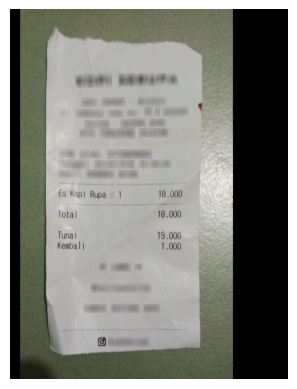

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
LABELS:
tensor([57525, 57527, 44306, 53692, 57528, 57553,  1314,  ...,  -100,  -100,
         -100,  -100,  -100,  -100,  -100])
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
DECODED LABELS:
<s_total><s_total_price> 18.000</s_total_price><s_changeprice> 1.000</s_changeprice><s_cashprice> 19.000</s_cashprice></s_total><s_menu><s_price> 18.000</s_price><s_nm> Es Kopi Rupa</s_nm><s_cnt> 1</s_cnt></s_menu></s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

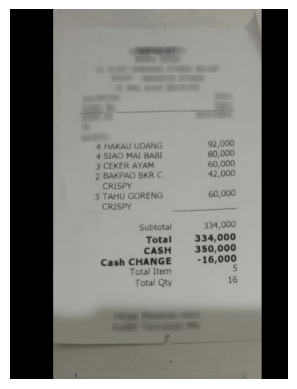

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
LABELS:
tensor([57525, 57527, 39260, 55604, 57528, 57549, 20017,  ...,  -100,  -100,
         -100,  -100,  -100,  -100,  -100])
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
DECODED LABELS:
<s_total><s_total_price> 334,000</s_total_price><s_menutype_cnt> 5</s_menutype_cnt><s_menuqty_cnt> 16</s_menuqty_cnt><s_changeprice> -16,000</s_changeprice><s_cashprice> 350,000</s_cashprice></s_total><s_sub_total><s_subtotal_price> 334,000</s_subtotal_price></s_sub_total><s_menu><s_price> 92,000</s_price><s_nm> HAKAU UDANG</s_nm><s_cnt> 4</s_cnt><sep/><s_price> 80,000</s_price><s_nm> SIAO MAI BABI</s_nm><s_cnt> 4</s_cnt><sep/><s_price> 60,000</s_pric

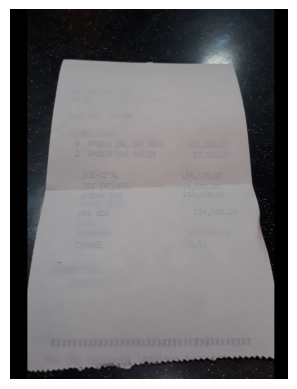

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
LABELS:
tensor([57525, 57527, 40331, 55604, 39539, 49351, 57528,  ...,  -100,  -100,
         -100,  -100,  -100,  -100,  -100])
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
DECODED LABELS:
<s_total><s_total_price> 154,000.00</s_total_price><s_creditcardprice> 154,000.00</s_creditcardprice><s_changeprice> 0.00</s_changeprice></s_total><s_sub_total><s_tax_price> 14,000.00</s_tax_price><s_subtotal_price> 154,000,00</s_subtotal_price></s_sub_total><s_menu><s_price> 132,000.00</s_price><s_nm> AMBUSH DBL CHS BURG</s_nm><s_cnt> 8</s_cnt><sep/><s_price> 22.000.00</s_price><s_nm> AMBUSH CHS BURGER</s_nm><s_cnt> 2</s_cnt></s_menu></s><pad><pad><p

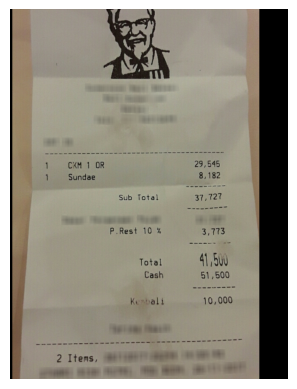

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
LABELS:
tensor([57525, 57527, 47651, 35815, 40556, 57528, 57551,  ...,  -100,  -100,
         -100,  -100,  -100,  -100,  -100])
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
DECODED LABELS:
<s_total><s_total_price> 41,500</s_total_price><s_menuqty_cnt> 2</s_menuqty_cnt><s_changeprice> 10,000</s_changeprice><s_cashprice> 51,500</s_cashprice></s_total><s_sub_total><s_tax_price> 3,773</s_tax_price><s_subtotal_price> 37,727</s_subtotal_price></s_sub_total><s_menu><s_price> 29,545</s_price><s_nm> CKM 1 OR</s_nm><s_cnt> 1</s_cnt><sep/><s_price> 8,182</s_price><s_nm> Sundae</s_nm><s_cnt> 1</s_cnt></s_menu></s><pad><pad><pad><pad><pad><pad><pad>

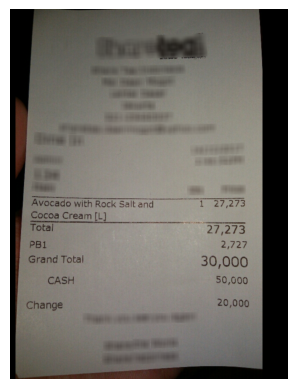

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
LABELS:
tensor([57525, 57527, 42830, 35815, 56239, 57528, 57553,  ...,  -100,  -100,
         -100,  -100,  -100,  -100,  -100])
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
DECODED LABELS:
<s_total><s_total_price> 30,000</s_total_price><s_changeprice> 20,000</s_changeprice><s_cashprice> 50,000</s_cashprice></s_total><s_sub_total><s_tax_price> 2,727</s_tax_price><s_subtotal_price> 27,273</s_subtotal_price></s_sub_total><s_menu><s_price> 27,273</s_price><s_nm> Avocado with Rock Salt and Cocoa Cream [L]</s_nm><s_cnt> 1</s_cnt></s_menu></s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

In [12]:
example_indices = np.random.randint(0, len(train_dataset), 5)

for i, index in enumerate(example_indices):
    print(dash_line)
    print("Example", i+1)
    visualize_data(train_dataset[int(index)])

# Look at Model Outputs

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=config.TRAINING.BATCH_SIZE.TRAIN, shuffle=True)

In [15]:
train_batch = next(iter(train_dataloader))

In [16]:
pixel_values, labels, target_sequence = train_batch
pixel_values, labels = pixel_values.to(device), labels.to(device)

In [17]:
donut_model = donut_model.to(device)

In [18]:
loss = donut_model(pixel_values, labels=labels).loss

In [19]:
loss

tensor(15.2361, device='cuda:0', grad_fn=<NllLossBackward0>)